In [11]:
import torch
import cv2

from d2go.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from d2go.utils.demo_predictor import DemoPredictor
from d2go.runner import Detectron2GoRunner

from matplotlib import pyplot as plt

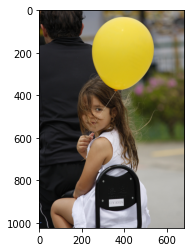

In [2]:
PATH = "/opt/infilect/dev/datasets/balloon_dataset/balloon/val/5555705118_3390d70abe_b.jpg"
im = cv2.imread(PATH)
_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(_im)

In [13]:
def prepare_for_launch():
    runner = Detectron2GoRunner()
    cfg = runner.get_default_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("mask_rcnn_fbnetv3a_C4.yaml"))
    cfg.MODEL_EMA.ENABLED = False
    cfg.DATASETS.TRAIN = ("balloon_train",)
    cfg.DATASETS.TEST = ("balloon_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("mask_rcnn_fbnetv3a_C4.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 1000    # 600 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
#     os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg, runner

cfg, runner = prepare_for_launch()
model = runner.build_model(cfg)


Arguments ['width_divisor', 'dw_skip_bnrelu', 'zero_last_bn_gamma'] skipped for op Conv2d


In [14]:
weights = '/opt/infilect/dev/repos/experiments/d2go_experiments/baloon_dataset/checkpoints/balloons_6000.pth'
# cfg_name = 'mask_rcnn_fbnetv3a_C4.yaml'
# model = model_zoo.get(cfg_name, trained=False)
_pretrained = torch.load(weights)
# print(_state_dict.keys())
model.load_state_dict(_pretrained.state_dict())
predictor = DemoPredictor(model)


In [15]:
outputs = predictor(im)

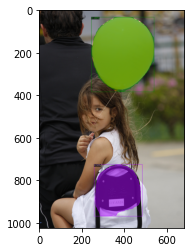

In [17]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("balloon_train"))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
res = out.get_image()[:, :, ::-1]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)